In [1]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 32 × Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, haswell)
  Threads: 2 on 32 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/cuda-10.1/lib64::/.singularity.d/libs
  JULIA_PKG_SERVER = https://mirrors.tuna.tsinghua.edu.cn/julia


In [15]:
using CSV
using DataFrames
using Turing
using Logging
using StatsBase
using Random
using LaTeXStrings
using StatsPlots

using Dagitty

using StatisticalRethinking
using StatisticalRethinking: link  # import explicitly, because Turing has link method also
using StatisticalRethinkingPlots

default(label=false)
Logging.disable_logging(Logging.Warn);

[ Info: Precompiling StatisticalRethinkingPlots [e1a513d0-d9d9-49ff-a6dd-9d2e9db473da]


# 5.1 Spurious association

## Code 5.1 Load and standardize data

In [64]:
using CairoMakie
using PairPlots

In [69]:
d = DataFrame(CSV.File("data/WaffleDivorce.csv"))

Row,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,String31,String3,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.0
7,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.0
8,Delaware,DE,0.9,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016
9,District of Columbia,DC,0.6,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.0


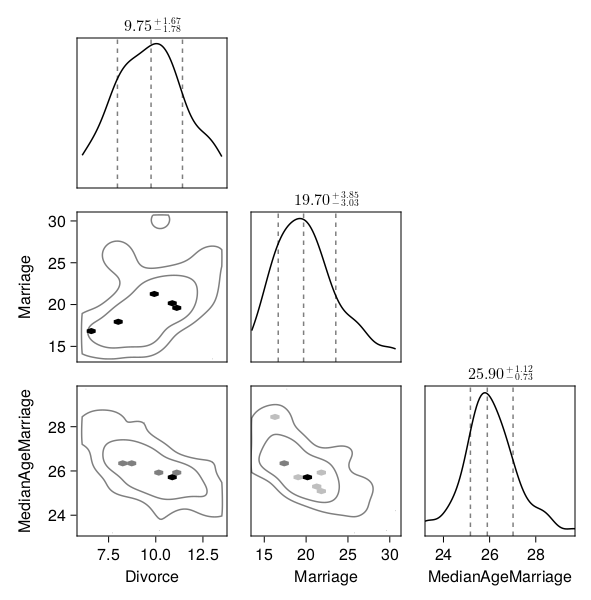

In [74]:
pairplot(d[!, [:Divorce, :Marriage, :MedianAgeMarriage]])

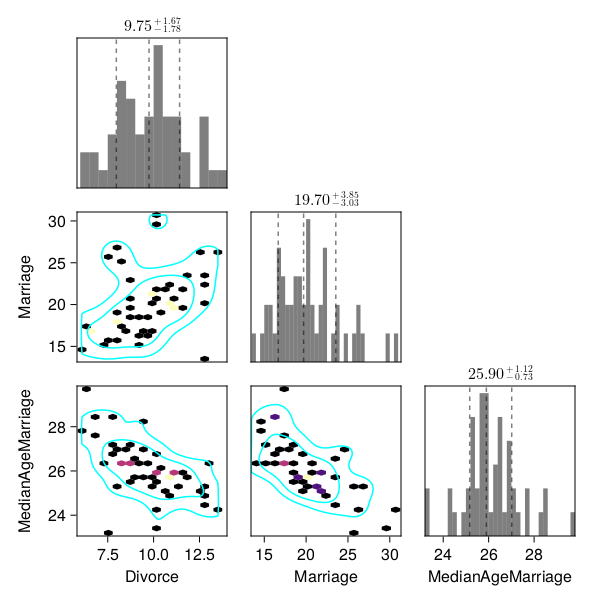

In [75]:

pairplot(
    d[!, [:Divorce, :Marriage, :MedianAgeMarriage]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

In [77]:
d[!,:D] = standardize(ZScoreTransform, d.Divorce)
d[!,:M] = standardize(ZScoreTransform, d.Marriage)
d[!,:A] = standardize(ZScoreTransform, d.MedianAgeMarriage);

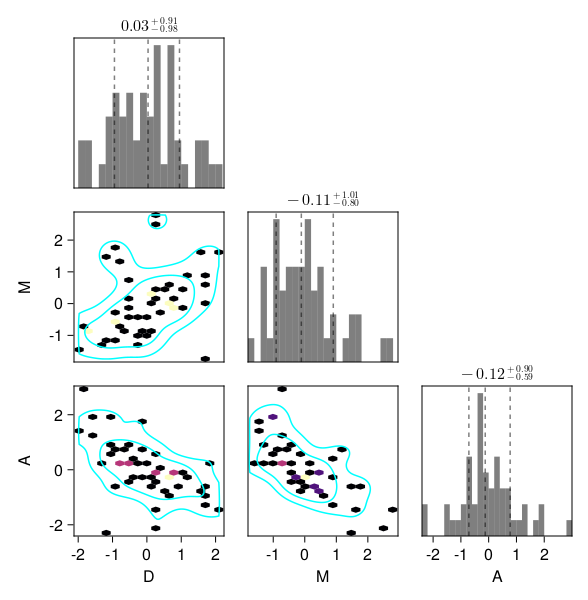

In [79]:
pairplot(
    d[!, [:D, :M, :A]] => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

## Code 5.2 stddev of median marriage age

In [4]:
std(d.MedianAgeMarriage)

1.2436303013880823

## Code 5.3 Model M5_1: Age at Marriage -> Divorce rate

In [36]:
Random.seed!(100)

@model function model_m5_1(A, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    μ = @. a + bA * A
    D ~ MvNormal(μ, σ)
end

# sample 1000 iterations with real data
m5_1 = sample(model_m5_1(d.A, d.D), NUTS(), 1000)
@show m5_1

m5_1 = MCMC chain (1000×15×1 Array{Float64, 3})


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.55 seconds
Compute duration  = 1.55 seconds
parameters        = σ, a, bA
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.8226    0.0803    0.0023   1218.6982   709.6336    1.0020    ⋯
           a   -0.0043    0.1016    0.0028   1310.2927   714.9924    1.0021    ⋯
          bA   -0.5724    0.1205    0.0033   1311.3950   762.5789    1.0004    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%   

In [27]:
m5_1_df = DataFrame(m5_1)
m5_1_df

Row,a,bA,σ
,Float64,Float64,Float64
1,0.0244318,-0.537766,0.941469
2,-0.011772,-0.453882,0.740754
3,-0.000747491,-0.774858,0.781651
4,-0.0536445,-0.390834,0.893161
5,0.0181929,-0.554014,0.757287
6,0.0181929,-0.554014,0.757287
7,0.0123558,-0.61193,0.837631
8,-0.0326483,-0.505217,0.792938
9,-0.016406,-0.561018,0.794867


In [35]:
# sample with no data
prior = sample(model_m5_1([0], [0]), Prior(), 1000)
@show prior

prior = MCMC chain (1000×4×1 Array{Float64, 3})


Chains MCMC chain (1000×4×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.03 seconds
Compute duration  = 0.03 seconds
parameters        = σ, a, bA
internals         = lp

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

           σ    0.9791    0.9977    0.0328   927.5421    967.9478    1.0000    ⋯
           a    0.0060    0.1928    0.0061   983.0459    896.5193    0.9995    ⋯
          bA    0.0414    0.4964    0.0175   807.8976   1025.7469    0.9992    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.0239    0.2664    0.6545    1.3919    3.7179
           a   -0.3774   -0.1266    0.0103    0

In [29]:
prior_df = DataFrame(prior);
prior_df

Row,a,bA,σ
,Float64,Float64,Float64
1,-0.0952983,0.346801,2.80228
2,0.325326,0.0330887,0.0767166
3,-0.0309668,-0.198111,0.50455
4,-0.109984,0.764847,0.407339
5,0.233796,-0.526402,0.770479
6,-0.271454,-0.615795,2.35955
7,0.701263,-0.048402,0.393459
8,-0.0821773,1.42475,1.10033
9,0.0981873,0.412537,0.67552


## Code 5.4 Simulate from priors

  0.000050 seconds (12 allocations: 63.672 KiB)
size(μ) = (2,)
size(μ[1]) = (1000,)
size(vcat(μ)) = (2,)
size(vcat(μ...)) = (2000,)
size(vcat(μ')) = (1, 2)
size(vcat(μ'...)) = (2, 1000)
size(hcat(μ)) = (2, 1)
size(hcat(μ...)) = (1000, 2)
size(hcat(μ')) = (1, 2)
size(hcat(μ'...)) = (1, 2000)
size(μ) = (1000, 2)


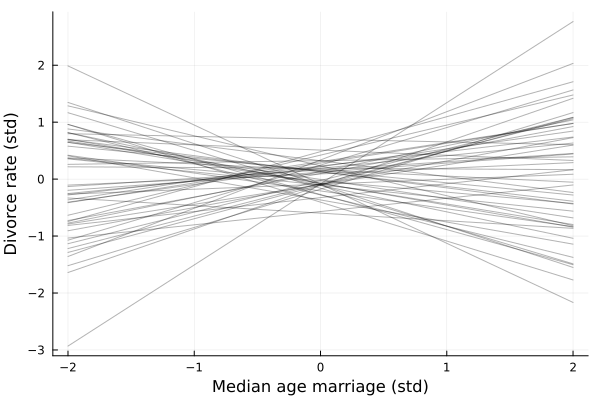

In [22]:
# calculate μ for every prior sample on age=-2 and age=2
bounds = [-2, 2]
@time μ = link(prior_df, [:a, :bA], bounds)
@show size(μ)
@show size(μ[1])
@show size(vcat(μ))
@show size(vcat(μ...))
@show size(vcat(μ'))
@show size(vcat(μ'...))
@show size(hcat(μ))
@show size(hcat(μ...))
@show size(hcat(μ'))
@show size(hcat(μ'...))

μ = hcat(μ...);
@show size(μ)

p = plot(xlab="Median age marriage (std)", ylab="Divorce rate (std)")
for μₚ ∈ first(eachrow(μ), 50)
    plot!(bounds, μₚ; c=:black, alpha=0.3)
end
display(p)

In [47]:
i = 0
for μₚ ∈ first(eachrow(μ), 50)
    i+=1
    #println(size(hcat(μₚ...)))
end
i

50

In [50]:
i=0
for μₚ ∈ eachrow(μ)
    i+=1
    #println(size(hcat(μₚ...)))
end
i

1000

## Code 5.5 Plot M5_1 (Divorce-rate ~ Age at marriage) and 89%-CI/PI(Percentile Interval)

size(μ) = (30,)
size(μ) = (1000, 30)
size(μ_mean) = (30,)
size(μ_PI) = (30,)
size(μ_PI) = (30, 2)


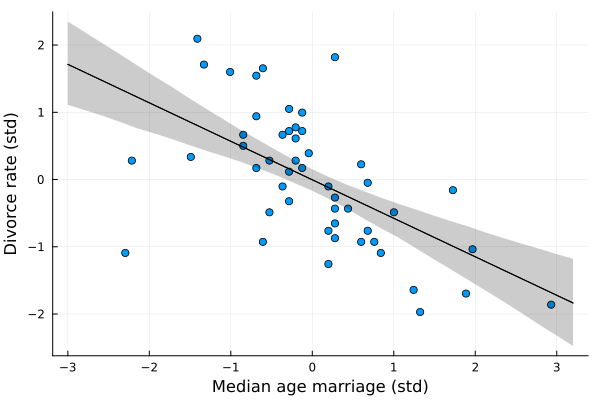

In [54]:
A_seq = range(-3, 3.2; length=30)

μ = link(m5_1_df, [:a, :bA], A_seq)
@show size(μ)

μ = hcat(μ...)
@show size(μ)

μ_mean = mean.(eachcol(μ))
@show size(μ_mean)

μ_PI = PI.(eachcol(μ))
@show size(μ_PI)

μ_PI = vcat(μ_PI'...)
@show size(μ_PI)

@df d scatter(:A, :D; xlab="Median age marriage (std)", ylab="Divorce rate (std)")
plot!(A_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

## Code 5.6 M5_2: Marriage rate ->  Divorce-rate and 89%-CI/PI(Percentile Interval)

In [59]:
Random.seed!(100)

@model function model_m5_2(M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    μ = @. a + bM * M
    D ~ MvNormal(μ, σ)
end

@time m5_2 = sample(model_m5_2(d.M, d.D), NUTS(), 1000)
print(m5_2)
m5_2_df = DataFrame(m5_2);
m5_2_df

  2.430190 seconds (1.90 M allocations: 169.482 MiB, 2.74% gc time, 89.34% compilation time: 84% of which was recompilation)
Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:varname_to_symbol, :start_time, :stop_time), Tuple{OrderedCollections.OrderedDict{AbstractPPL.VarName, Symbol}, Float64, Float64}}}

Row,a,bM,σ
,Float64,Float64,Float64
1,-0.099085,0.431999,0.970973
2,-0.00898628,0.188715,0.869539
3,0.00576532,0.510824,0.967043
4,0.0023617,0.135649,0.873527
5,-0.00583311,0.249348,0.918568
6,0.103296,0.406378,0.878395
7,0.21369,0.222688,1.22729
8,0.26529,0.345047,1.01489
9,-0.0668167,0.329049,0.952299


In [111]:
m5_2

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.54 seconds
Compute duration  = 1.54 seconds
parameters        = σ, a, bM
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.9511    0.0939    0.0028   1141.1385   572.7905    1.0027    ⋯
           a    0.0025    0.1157    0.0034   1132.6733   771.3853    1.0010    ⋯
          bM    0.3513    0.1302    0.0037   1285.6732   699.6500    1.0007    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%   

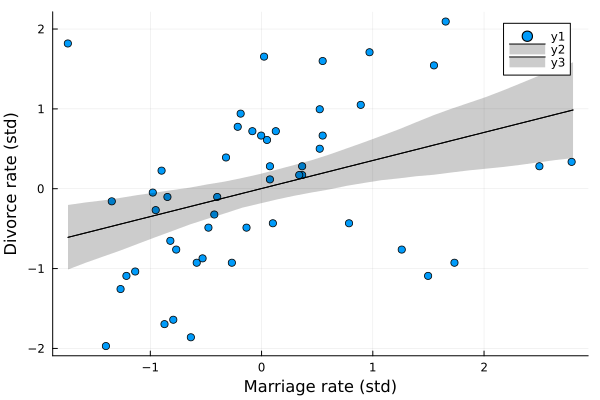

In [11]:
M_seq = range(-1.74, 2.8; length=30)

μ = link(m5_2_df, [:a, :bM], M_seq)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df d scatter(:M, :D; xlab="Marriage rate (std)", ylab="Divorce rate (std)")
plot!(M_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.2)

## Code 5.7 DAG1: (Directed Acyclic Graph)/Causal relationship for Divorce rate

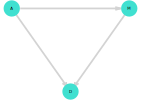

In [60]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
drawdag(g, [0, 1, 2], [0, 1, 0])

In [61]:
?drawdag

search: drawdag



```
drawdag(dag; layout=spring_layout, ...)
```

Draws dag with given layout method (check GraphPlot package for their description)

---

```
drawdag(dag, locs_x, locs_y)
```

Draws dag with given locations of every node

# Examples

```julia
julia> g = DAG(:A => :C, :C => :B)
DAG: {3, 2} directed simple Int64 graph with labels [:A, :B, :C])

julia> drawdag(g, [0, 0, 1], [0, 1, 1])
```


## Code 5.8 DAG2 and there is one conditional independence

implied_conditional_independencies(g) = ConditionalIndependence[ConditionalIndependence(:D, :M, [:A])]


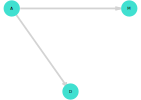

In [63]:
g = Dagitty.DAG(:A => :M, :A => :D)
@show implied_conditional_independencies(g)
drawdag(g, [0, 1, 2], [0, 1, 0])

Conditoinal indendence: P(D,M|A) = P(D|A) * P(M|A)

## Code 5.9 No conditional independence for DAG1

In [11]:
g = Dagitty.DAG(:A => :M, :A => :D, :M => :D)
implied_conditional_independencies(g)

ConditionalIndependence[]

## Code 5.10 M5_3: Age at marriage + Marriage-rate -> Divorce rate

In [80]:
@model function model_m5_3(A, M, D)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
end

m5_3 = sample(model_m5_3(d.A, d.M, d.D), NUTS(), 1000)
m5_3_df = DataFrame(m5_3)
precis(m5_3_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.0004  0.0983  -0.1538  -0.0034   0.1551  ▁▁▁▂▄▇██▇▄▂▁▁▁ │
│    bA │ -0.6045   0.161  -0.8547  -0.6058  -0.3498     ▁▁▁▃▆██▆▃▁▁ │
│    bM │ -0.0543  0.1604  -0.3145  -0.0538   0.1995     ▁▂▄▆█▆▄▂▁▁▁ │
│     σ │  0.8268  0.0831   0.7062   0.8211   0.9637  ▁▂▅▇█▆▄▂▁▁▁▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 5.11 Plot coefficients of different models above

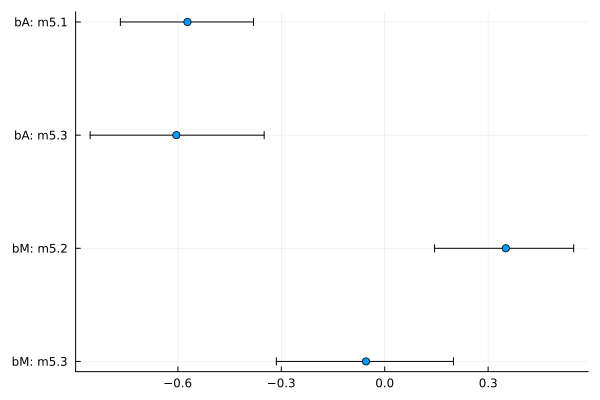

In [81]:
coeftab_plot(m5_1_df, m5_2_df, m5_3_df; pars=(:bA, :bM), names=["m5.1", "m5.2", "m5.3"])

## Code 5.12 Plot coefficients of a simulated model (A -> M, A-> D but no causality between M and D)

In [82]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age));

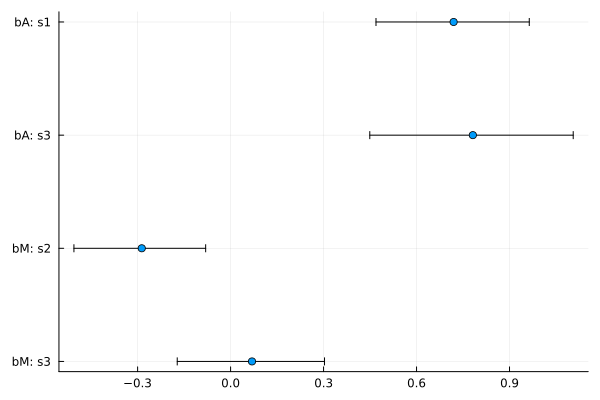

In [83]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

### 5.12.1 Simulate a A -> M, A+M -> D model and plot coefficients of the fitted model

In [84]:
Random.seed!(100)
N = 50
age = rand(Normal(), N)
mar = rand.(Normal.(-age))
div = rand.(Normal.(age .+ mar));

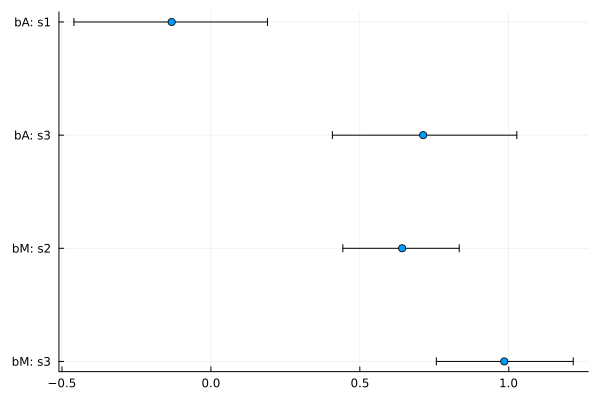

In [85]:
s1 = DataFrame(sample(model_m5_1(age, div), NUTS(), 1000))
s2 = DataFrame(sample(model_m5_2(mar, div), NUTS(), 1000))
s3 = DataFrame(sample(model_m5_3(age, mar, div), NUTS(), 1000));
coeftab_plot(s1, s2, s3; pars=(:bA, :bM), names=["s1", "s2", "s3"])

## Code 5.13 M5.4: An Age -> Marriage_rate model

In [86]:
Random.seed!(100)

@model function model_m5_4(A, M)
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ = @. a + bAM * A
    M ~ MvNormal(μ, σ)
end

m5_4 = sample(model_m5_4(d.A, d.M), NUTS(), 1000)
m5_4_df = DataFrame(m5_4);

In [108]:
m5_4

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.55 seconds
Compute duration  = 5.55 seconds
parameters        = σ, a, bAM
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

           σ    0.7157    0.0748    0.0024   1040.7863   541.3318    1.0010    ⋯
           a    0.0001    0.0823    0.0023   1289.0902   836.3366    0.9990    ⋯
         bAM   -0.6904    0.1037    0.0029   1325.5622   644.1833    1.0068    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%  

## Code 5.14 Plot residuals of Age -> Marriage-rate model

In [87]:
mu = link(m5_4_df, [:a, :bAM], d.A);
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_resid = mu_mean .- d.M;

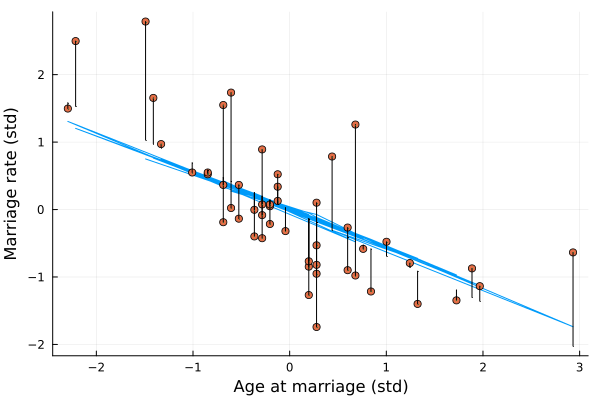

In [103]:
# Side-note: how to plot the residuals
# getting yerr - list of 2-tuples with distance to the regression line
yerr = collect(zip(-clamp.(mu_resid, -Inf, -0.0), clamp.(mu_resid, 0, Inf)));

StatsPlots.plot(d.A, mu_mean; xlab="Age at marriage (std)", ylab="Marriage rate (std)")
StatsPlots.scatter!(d.A, d.M)
StatsPlots.scatter!(d.A, d.M; yerr=yerr, markersize=0)

## Code 5.15 Simulate M5_3

In [89]:
fun = (r,(a,m)) -> r.a + r.bA*a + r.bM*m
mu = link(m5_3_df, fun, zip(d.A, d.M))
mu = hcat(mu...)
mu_mean = mean.(eachcol(mu))
mu_PI = PI.(eachcol(mu))
mu_PI = vcat(mu_PI'...);

fun = (r, (a,m)) -> Normal(r.a+r.bA*a+r.bM*m, r.σ)
D_sim = simulate(m5_3_df, fun, zip(d.A, d.M))
D_sim = vcat(D_sim'...);
D_PI = PI.(eachcol(D_sim))
D_PI = vcat(D_PI'...);

### Code 5.16 Plot simulations of M5_3

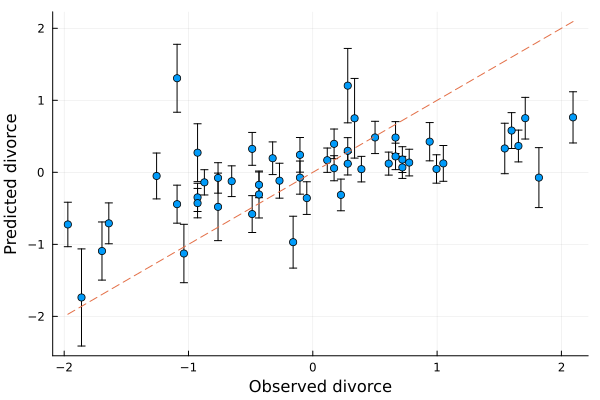

In [90]:
yerr = mu_PI[:,2] .- mu_mean
StatsPlots.scatter(d.D, mu_mean; xlab="Observed divorce", ylab="Predicted divorce", yerr=yerr)
StatsPlots.plot!(x->x; style=:dash)

### Code 5.17 Find the outlier states of M5_3

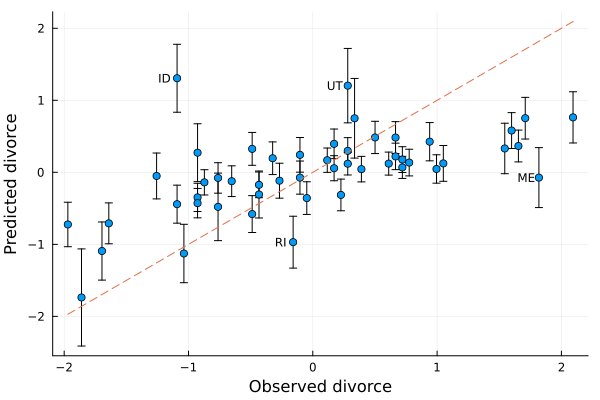

In [91]:
loc_flags = d.Loc .∈ (["ID", "UT", "RI", "ME"],);
loc_idxes = findall(loc_flags);
anns = [
    (d.D[idx] - 0.1, mu_mean[idx], (d.Loc[idx], 8))
    for idx in loc_idxes
]
annotate!(anns)

## Code 5.18 Simulate spurious association

x_real ~ N(0,1)

x_spur ~ N(x_real, 1)

y ~ N(x_real, 1)

$$ y = a + \beta_1 * x_{real} + \beta_2 * x_{spur} + \epsilon$$

=> $\beta_2 = 0 $ => $x_{spur}$ is useless.

In [109]:
Random.seed!(100)
N = 100
x_real = rand(Normal(), N)
x_spur = rand.(Normal.(x_real))
y = rand.(Normal.(x_real))
df = DataFrame(:y => y, :x_real => x_real, :x_spur => x_spur);

In [107]:
df

Row,y,x_real,x_spur
,Float64,Float64,Float64
1,1.58308,1.0516,0.542426
2,-1.38233,-0.676855,-1.20993
3,-0.873461,-0.167043,-0.821533
4,-1.19174,-0.943461,-2.41842
5,-0.0975013,0.0437185,0.695274
6,0.186308,-0.381812,-2.86091
7,-1.61618,-0.731897,-1.1923
8,0.881373,0.849668,1.17135
9,-1.26316,0.364817,-1.33369


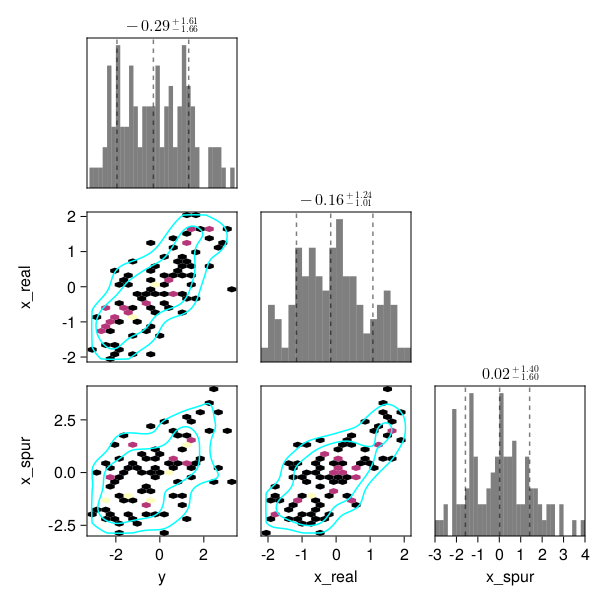

In [110]:

pairplot(
    df => (
        #PairPlots.HexBin(colormap=Makie.cgrad([:transparent, :black])),
        PairPlots.HexBin(colormap=:magma), 
        PairPlots.Scatter(filtersigma=2, color=:black),
        #PairPlots.Contour(color=:black),
        PairPlots.Contour(color=:cyan, strokewidth=5),

        # New:
        PairPlots.MarginHist(),
        PairPlots.MarginConfidenceLimits(),
    )
)

## Code 5.19 M5_3A: Simulate  A → D ← M and A → M

In [93]:
d1 = DataFrame(CSV.File("data/WaffleDivorce.csv"))
d = DataFrame(
    :D => standardize(ZScoreTransform, d1.Divorce),
    :M => standardize(ZScoreTransform, d1.Marriage),
    :A => standardize(ZScoreTransform, d1.MedianAgeMarriage),
);

@model function model_m5_3A(A, M, D)
    # A → D ← M
    σ ~ Exponential(1)
    a ~ Normal(0, 0.2)
    bA ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    μ = @. a + bA * A + bM * M
    D ~ MvNormal(μ, σ)
    # A → M
    σ_M ~ Exponential(1)
    aM ~ Normal(0, 0.2)
    bAM ~ Normal(0, 0.5)
    μ_M = @. aM + bAM * A
    M ~ MvNormal(μ_M, σ_M)
end

m5_3A = sample(model_m5_3A(d.A, d.M, d.D), NUTS(), 1000)
m5_3A_df = DataFrame(m5_3A)
precis(m5_3A_df)

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.0053  0.0964  -0.1468   0.0052   0.1591   ▁▁▂▄▆██▆▄▃▁▁▁ │
│    aM │  0.0032  0.0868  -0.1332   0.0025   0.1394  ▁▁▂▃▆██▆▄▂▁▁▁▁ │
│    bA │ -0.6055  0.1614  -0.8738  -0.6028  -0.3492     ▁▂▃▆██▆▃▁▁▁ │
│   bAM │ -0.6951  0.1041  -0.8686  -0.6918   -0.529   ▁▁▂▄▆▇█▇▄▂▁▁▁ │
│    bM │ -0.0628  0.1594  -0.3134  -0.0642   0.1965     ▁▁▂▄▇█▆▃▂▁▁ │
│     σ │  0.8269  0.0844    0.699   0.8211   0.9637   ▁▂▄██▇▄▂▁▁▁▁▁ │
│   σ_M │  0.7102  0.0707   0.6084   0.7059   0.8296      ▁▁▆██▅▂▂▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


## Code 5.20 simulate a range of A (Age at marriage)

In [94]:
A_seq = range(-2, 2; length=30);

## Code 5.21 Simulate intervention models

In [95]:
s_M, s_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * A_seq), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * A_seq + r.bM * M), r.σ))
    push!(s_M, M)
    push!(s_D, D)
end

s_M = vcat(s_M'...)
s_D = vcat(s_D'...);

## Code 5.22 Plot simulated data

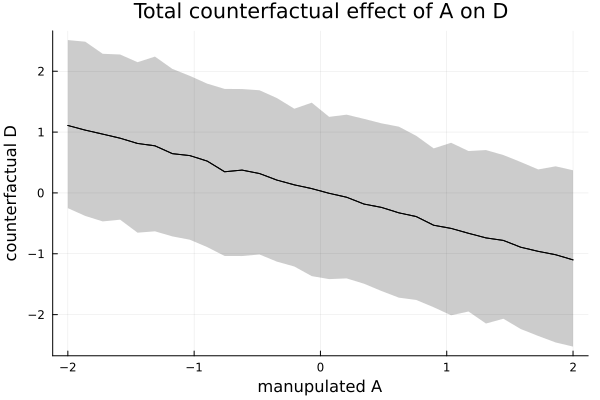

In [96]:
μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    A_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual D",
    title="Total counterfactual effect of A on D"
)

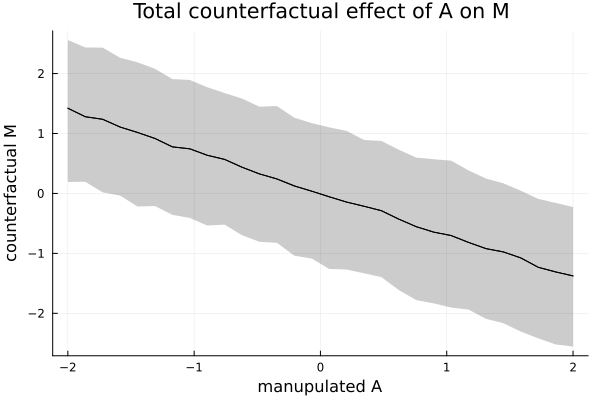

In [97]:
μ_M = mean.(eachcol(s_M))
PI_M = vcat(PI.(eachcol(s_M))'...)

plot(
    A_seq, [μ_M, μ_M]; 
    fillrange=PI_M, fillalpha=0.2, color=:black,
    xlab="manupulated A", ylab="counterfactual M",
    title="Total counterfactual effect of A on M"
)

## Code 5.23

In [98]:
sim2_A = @. ([20, 30] - 26.1) / 1.24;
s2_M, s2_D = [], []

for r ∈ eachrow(m5_3A_df)
    M = rand(MvNormal((@. r.aM + r.bAM * sim2_A), r.σ_M))
    D = rand(MvNormal((@. r.a + r.bA * sim2_A + r.bM * M), r.σ))
    push!(s2_M, M)
    push!(s2_D, D)
end

s2_M = vcat(s2_M'...)
s2_D = vcat(s2_D'...);
mean(s2_D[:,2] - s2_D[:,1])

-4.532437733040558

## Code 5.24

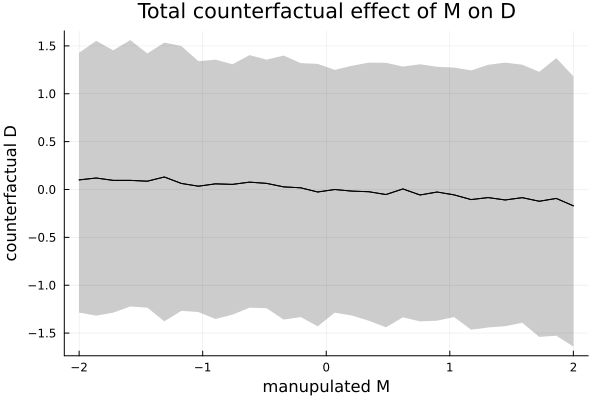

In [99]:
M_seq = range(-2, 2; length=30)
s_D = []

for r ∈ eachrow(m5_3A_df)
    # A is zero, so, we drop it from the μ term
    D = rand(MvNormal((@. r.a + r.bM * M_seq), r.σ))
    push!(s_D, D)
end

s_D = vcat(s_D'...);

μ_D = mean.(eachcol(s_D))
PI_D = vcat(PI.(eachcol(s_D))'...)

plot(
    M_seq, [μ_D, μ_D]; 
    fillrange=PI_D, fillalpha=0.2, color=:black,
    xlab="manupulated M", ylab="counterfactual D",
    title="Total counterfactual effect of M on D"
)

## Code 5.25

In [100]:
A_seq = range(-2, 2; length=30);

In [106]:
A_seq

-2.0:0.13793103448275862:2.0

## Code 5.26

In [101]:
s_M = simulate(m5_3A_df, (r,a) -> Normal(r.aM + r.bAM*a), A_seq)
s_M = vcat(s_M'...);

In [105]:
s_M

1000×30 Matrix{Float64}:
  1.92794    1.54085    1.15432    …  -0.767491   -2.7444     -3.46183
  0.908773  -0.479218   0.0938201      0.585955   -0.389276   -2.13534
 -0.413785  -1.43165   -0.581544      -2.78697    -0.759363   -2.34133
  1.59478    1.12136    1.27017       -1.04614    -1.83813    -1.15212
  2.2436     0.72524    1.40694        0.271442   -1.55346     0.0525702
  1.90278    0.665031  -0.588684   …  -0.452422   -0.981543   -0.909611
  1.1571     1.71416    1.42744       -0.0405939   0.0214152  -0.835301
  1.23463    2.83735    3.03306       -2.09665    -0.831248   -3.08976
  2.92929    1.23717    2.67232       -0.520378    0.392671   -3.09773
  1.98068   -0.282545   1.68077       -1.69156    -1.65223     0.970884
  0.343166   0.551395  -0.899405   …  -2.23484    -1.49966    -1.02469
  0.528834   1.93167    1.18061       -2.32996    -1.73243    -1.7349
  1.85232    1.52049    0.976049      -1.03517    -0.614021   -2.24822
  ⋮                                ⋱            

## Code 5.27

In [102]:
# joining M into dataframe with parameters
t = DataFrame(m5_3A_df)
t[!,:M] = collect(eachrow(s_M));

s_D = simulate(t, (r,(a,m)) -> Normal(r.a + r.bA*a + r.bM*r.M[m], r.σ), zip(A_seq, 1:30))
s_D = vcat(s_D'...);

In [104]:
s_D

1000×30 Matrix{Float64}:
  0.647393   0.712761    1.46372    …  -0.740954  -1.693     -2.4863
  2.0645     1.4878      0.410368      -0.455286  -2.24934   -1.03512
  2.72004    0.507924    1.19388       -2.70965   -3.75812    0.38008
  1.7601     0.972189    0.865447      -1.82642   -1.93089   -0.711996
  1.65041    1.30544     0.436759       0.550377  -0.875726   0.337594
  1.5951     1.63423     1.55044    …   0.922937   0.431729  -1.37628
  1.84691    1.88403     0.873754      -1.81622   -3.99179   -0.807178
  1.72888    0.0868996   1.44738       -1.39575   -0.40758   -0.670864
  2.0784     1.42523     0.985569      -1.2453    -0.435143   0.229634
 -0.56398    1.55143     0.0992896     -0.250469   0.479525  -1.51153
  0.281498  -0.148972   -1.79741    …  -0.795934  -0.907405  -2.53969
  1.49227    1.2304     -0.508986      -0.426891   0.598347  -0.550056
  1.97431    0.825131    1.40387       -0.542382  -1.85391   -1.73423
  ⋮                                 ⋱                       

# 5.2 Masked relationship

## Code 5.28

In [35]:
d = DataFrame(CSV.File("data/milk.csv",  missingstring="NA"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

describe(d)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,clade,,Ape,,Strepsirrhine,0
2,species,,A palliata,,Symphalangus syndactylus,0
3,kcal_per_g,0.641724,0.46,0.6,0.97,0
4,perc_fat,33.9903,3.93,36.84,55.51,0
5,perc_protein,16.4034,7.37,15.8,25.3,0
6,perc_lactose,49.6062,27.09,48.64,71.91,0
7,mass,14.7269,0.12,3.47,97.72,0
8,neocortex_perc,67.5759,55.16,68.85,76.3,12


## Code 5.29

In [36]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g)
d[!,:M] = standardize(ZScoreTransform, log.(d.mass))

# column contains missing values, need to propagate them on standartization
d[!,:N] = d.neocortex_perc
non_miss = findall(!ismissing, d.N);
d[non_miss,:N] = standardize(ZScoreTransform, disallowmissing(d.N[non_miss]));

## Code 5.30

Expected to fail

In [37]:
@model function model_m5_5_draft(N, K)
    a ~ Normal(0, 1)
    bN ~ Normal(0, 1)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

try
    m5_5_draft = sample(model_m5_5_draft(d.N, d.K), NUTS(), 1000)
catch e
    if isa(e, MethodError)
        s = sprint(showerror, e)
        println(s)
    end
end

MethodError: no method matching MvNormal(::Vector{Union{Missing, Float64}}, ::Float64)
Closest candidates are:
  MvNormal(!Matched::Tracker.TrackedVector{var"#s52", A} where {var"#s52"<:Real, A}, ::Real) at /home/shmuma/.julia/packages/DistributionsAD/yw5cH/src/tracker.jl:462
  MvNormal(!Matched::AbstractVector{var"#s487"} where var"#s487"<:Real, ::Real) at deprecated.jl:70
  MvNormal(!Matched::Int64, ::Real) at deprecated.jl:70


## Code 5.31

In [38]:
d.neocortex_perc

29-element Vector{Union{Missing, Float64}}:
 -2.0801960251136564
   missing
   missing
   missing
   missing
 -0.5086412889378672
 -0.5086412889378672
  0.010742472484833622
   missing
  0.21346968258853227
 -1.4619618058717947
 -0.9861392631490621
 -1.2156733770681267
  ⋮
  0.47483699478834385
   missing
  0.9757910098379835
   missing
 -0.007687273888229892
   missing
  0.6172486713074732
  0.8417564907611553
   missing
  0.44635465948451797
  1.4616661414914773
  1.3259561909261903

## Code 5.32

In [39]:
dcc = d[completecases(d[!,[:K,:N,:M]]),:];

## Code 5.33

In [40]:
m5_5_draft = sample(model_m5_5_draft(dcc.N, dcc.K), NUTS(), 1000);

## Code 5.34

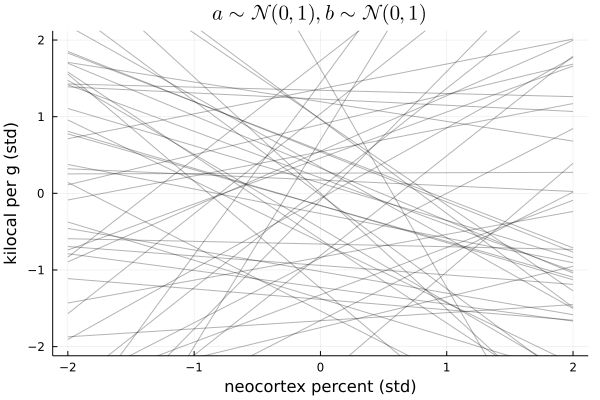

In [41]:
prior = sample(model_m5_5_draft(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)
xseq = [-2, 2]
μ = link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,1), b \sim \mathcal{N}(0,1)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p, xseq, y; c=:black, alpha=0.3)
end
p

## Code 5.35

In [42]:
@model function model_m5_5(N, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N
    K ~ MvNormal(μ, σ)
end

m5_5 = sample(model_m5_5(dcc.N, dcc.K), NUTS(), 1000)
m5_5_df = DataFrame(m5_5);

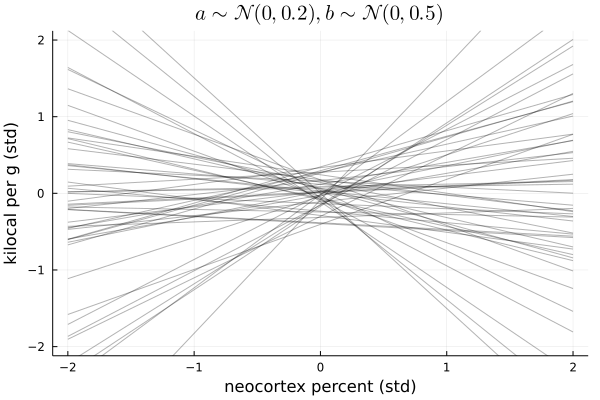

In [43]:
prior = sample(model_m5_5(dcc.N, dcc.K), Prior(), 1000)
prior_df = DataFrame(prior)

μ = link(prior_df, [:a, :bN], xseq)
μ = hcat(μ...);

p2 = plot(; xlim=xseq, ylim=xseq, 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)", 
    title=L"a \sim \mathcal{N}(0,0.2), b \sim \mathcal{N}(0,0.5)"
)
for y ∈ first(eachrow(μ), 50)
    plot!(p2, xseq, y; c=:black, alpha=0.3)
end
p2

## Code 5.36

In [44]:
precis(m5_5_df)

┌───────┬───────────────────────────────────────────────────────┐
│ param │   mean     std     5.5%     50%   94.5%     histogram │
├───────┼───────────────────────────────────────────────────────┤
│     a │ 0.0341  0.1712  -0.2582  0.0324  0.3065  ▁▁▁▂▄▆█▆▃▂▁▁ │
│    bN │ 0.1363   0.239  -0.2486  0.1334  0.5227    ▁▁▂▅█▇▃▁▁▁ │
│     σ │  1.108  0.1985   0.8612  1.0778    1.45    ▁██▅▂▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────┘


## Code 5.37

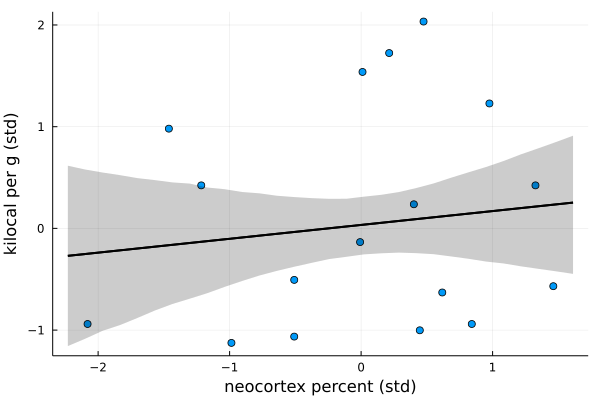

In [45]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_5_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:N, :K; xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

## Code 5.38

In [46]:
@model function model_m5_6(M, K)
    a ~ Normal(0, 0.2)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bM * M
    K ~ MvNormal(μ, σ)
end

m5_6 = sample(model_m5_6(dcc.M, dcc.K), NUTS(), 1000)
m5_6_df = DataFrame(m5_6)
precis(m5_6_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.0452  0.1615  -0.2122   0.0389  0.3085    ▁▁▂▄▇█▆▄▂▁▁▁ │
│    bM │ -0.2673  0.2027  -0.5915  -0.2727  0.0577  ▁▁▂▄▆███▅▃▁▁▁▁ │
│     σ │  1.0601  0.1975   0.7949   1.0289  1.4031  ▁▂▆██▆▄▃▂▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


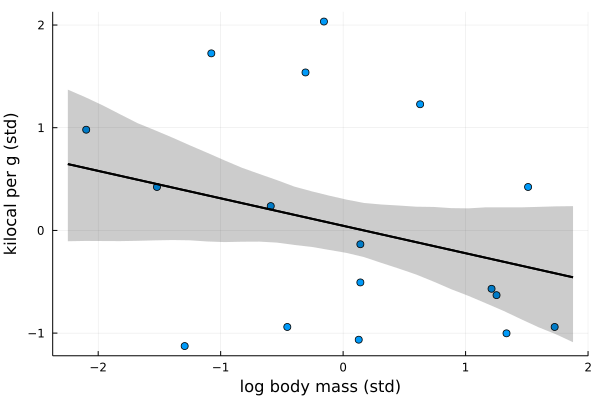

In [47]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = link(m5_6_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

@df dcc scatter(:M, :K; xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

In [48]:
@model function model_m5_7(N, M, K)
    a ~ Normal(0, 0.2)
    bN ~ Normal(0, 0.5)
    bM ~ Normal(0, 0.5)
    σ ~ Exponential(1)
    μ = @. a + bN * N + bM * M
    K ~ MvNormal(μ, σ)
end

m5_7 = sample(model_m5_7(dcc.N, dcc.M, dcc.K), NUTS(), 1000)
m5_7_df = DataFrame(m5_7)
precis(m5_7_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │  0.0664  0.1463  -0.1778   0.0711    0.302  ▁▂▃▇██▄▂▁▁▁ │
│    bM │ -0.6285  0.2483  -0.9994  -0.6536  -0.2093  ▁▂▅█▇▃▂▁▁▁▁ │
│    bN │     0.6  0.2716   0.1339   0.6089    1.018    ▁▁▂▄██▅▂▁ │
│     σ │  0.8726  0.1931   0.6398   0.8379   1.2128    ▁██▃▁▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


## Code 5.40

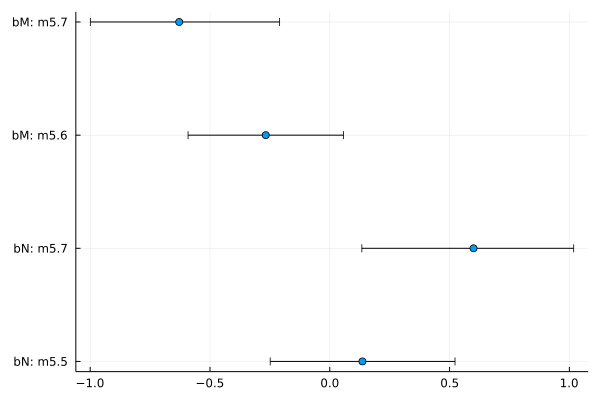

In [49]:
coeftab_plot(m5_7_df, m5_6_df, m5_5_df; pars=(:bM, :bN), names=("m5.7", "m5.6", "m5.5"))

## Code 5.41

The code in the book corresponds to the bottom-right figure, which keeps N=0 (despite stated in the text).

Below is the code to produce the bottom-left figure (M=0).

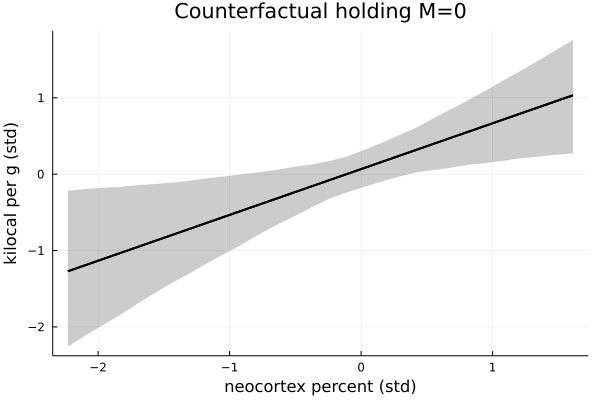

In [50]:
xseq = range(minimum(dcc.N) - 0.15, maximum(dcc.N) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bN], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding M=0", 
    xlab="neocortex percent (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

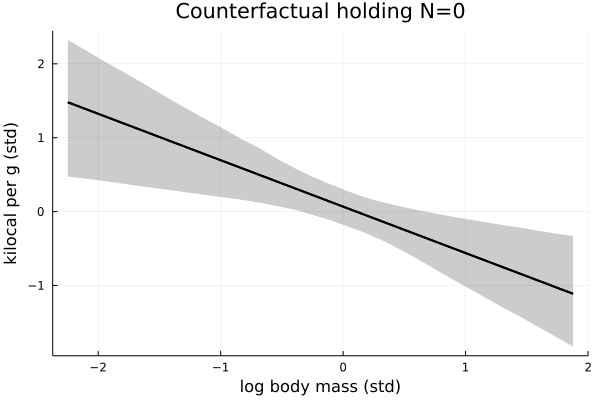

In [51]:
xseq = range(minimum(dcc.M) - 0.15, maximum(dcc.M) + 0.15; length=30)
μ = link(m5_7_df, [:a, :bM], xseq);
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...)

plot(title="Counterfactual holding N=0", 
    xlab="log body mass (std)", ylab="kilocal per g (std)")
plot!(xseq, [μ_mean, μ_mean]; lw=2, fillrange=μ_PI, fillalpha=0.2, color=:black)

## Code 5.42

In [52]:
# M → K ← N
# M → N
Random.seed!(100)
n = 100
M = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ M]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim = DataFrame(:K => K, :N => N, :M => M);

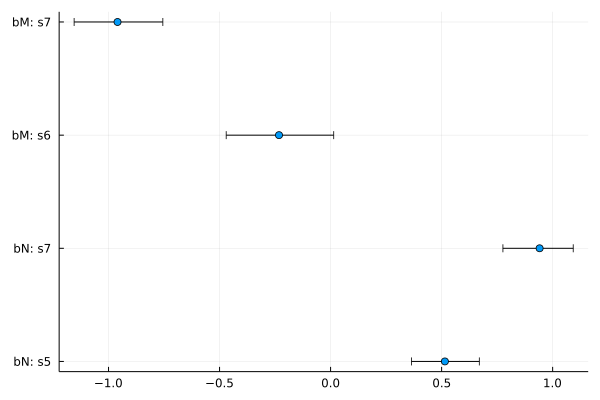

In [53]:
s5 = sample(model_m5_5(d_sim.N, d_sim.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim.M, d_sim.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim.N, d_sim.M, d_sim.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

## Code 5.43

In [54]:
Random.seed!(100)

# M → K ← N
# N → M
n = 100
N = rand(Normal(), n)
M = [rand(Normal(μ)) for μ ∈ N]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim2 = DataFrame(:K => K, :N => N, :M => M);

# M → K ← N
# M ← U → N
n = 100
U = rand(Normal(), n)
N = [rand(Normal(μ)) for μ ∈ U]
M = [rand(Normal(μ)) for μ ∈ U]
K = [rand(Normal(μ)) for μ ∈ N .- M] 
d_sim3 = DataFrame(:K => K, :N => N, :M => M);

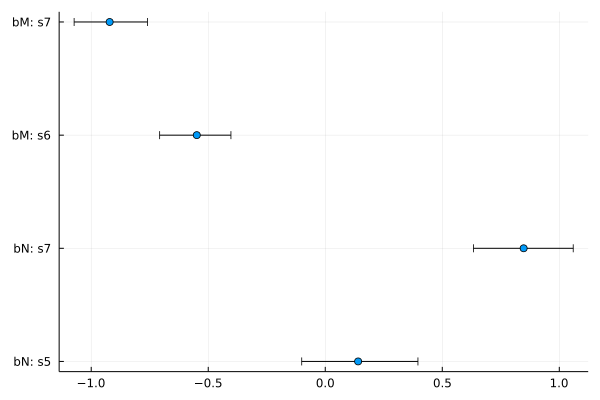

In [55]:
s5 = sample(model_m5_5(d_sim2.N, d_sim2.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim2.M, d_sim2.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim2.N, d_sim2.M, d_sim2.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

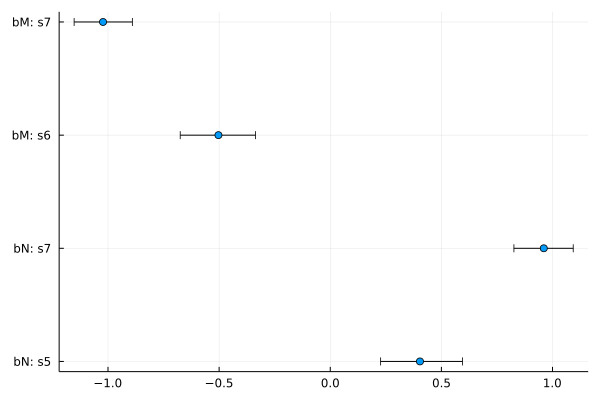

In [56]:
s5 = sample(model_m5_5(d_sim3.N, d_sim3.K), NUTS(), 1000)
s6 = sample(model_m5_6(d_sim3.M, d_sim3.K), NUTS(), 1000)
s7 = sample(model_m5_7(d_sim3.N, d_sim3.M, d_sim3.K), NUTS(), 1000)
s5_df = DataFrame(s5)
s6_df = DataFrame(s6)
s7_df = DataFrame(s7)
coeftab_plot(s7_df, s6_df, s5_df; pars=(:bM, :bN), names=("s7", "s6", "s5"))

## Code 5.44

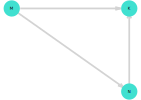

In [57]:
dag5_7 = Dagitty.DAG(:M => :K, :N => :K, :M => :N)
drawdag(dag5_7, [1, 0, 1], [0, 0, 1])

# equivalentDAGs is TODO in Dagitty.jl

# 5.3 Categorical variables

## Code 5.45

In [58]:
d = DataFrame(CSV.File("data/Howell1.csv"))
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,height,138.264,53.975,148.59,179.07,0,Float64
2,weight,35.6106,4.25242,40.0578,62.9926,0,Float64
3,age,29.3444,0.0,27.0,88.0,0,Float64
4,male,0.472426,0,0.0,1,0,Int64


## Code 5.46

In [59]:
cnt = 10_000
μ_female = rand(Normal(178, 20), cnt)
μ_male = rand(Normal(178, 20), cnt) + rand(Normal(0, 10), cnt)
precis(DataFrame(:μ_female => μ_female, :μ_male => μ_male))

┌──────────┬────────────────────────────────────────────────────────┐
│    param │    mean      std     5.5%      50%    94.5%  histogram │
├──────────┼────────────────────────────────────────────────────────┤
│ μ_female │ 177.916  19.8439  146.319  177.704  209.809   ▁▁▄██▃▁▁ │
│   μ_male │ 177.735   22.197  142.547  177.727  213.312  ▁▁▅██▄▁▁▁ │
└──────────┴────────────────────────────────────────────────────────┘


## Code 5.47

In [60]:
d[!,:sex] = ifelse.(d.male .== 1, 2, 1)
describe(d.sex)

Summary Stats:
Length:         544
Missing Count:  0
Mean:           1.472426
Minimum:        1.000000
1st Quartile:   1.000000
Median:         1.000000
3rd Quartile:   2.000000
Maximum:        2.000000
Type:           Int64


## Code 5.48

In [61]:
@model function model_m5_8(sex, height)
    σ ~ Uniform(0, 50)
    a ~ MvNormal([178, 178], 20)
    height ~ MvNormal(a[sex], σ)
end

m5_8 = sample(model_m5_8(d.sex, d.height), NUTS(), 1000)
m5_8_df = DataFrame(m5_8)
precis(m5_8_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ 134.925  1.6176  132.457  134.839  137.415  ▁▁▁▂▃▇█▇▆▃▁▁▁ │
│  a[2] │ 142.628  1.6932  139.945  142.576  145.316   ▁▁▁▂▄▇██▅▂▁▁ │
│     σ │ 27.4051  0.8342  26.1216  27.4125  28.8383  ▁▁▂▄███▆▃▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


## Code 5.49

In [62]:
m5_8_df[!,:diff_fm] = m5_8_df[:,"a[1]"] - m5_8_df[:,"a[2]"]
precis(m5_8_df)

┌─────────┬────────────────────────────────────────────────────────────┐
│   param │    mean     std      5.5%      50%    94.5%      histogram │
├─────────┼────────────────────────────────────────────────────────────┤
│    a[1] │ 134.925  1.6176   132.457  134.839  137.415  ▁▁▁▂▃▇█▇▆▃▁▁▁ │
│    a[2] │ 142.628  1.6932   139.945  142.576  145.316   ▁▁▁▂▄▇██▅▂▁▁ │
│       σ │ 27.4051  0.8342   26.1216  27.4125  28.8383  ▁▁▂▄███▆▃▁▁▁▁ │
│ diff_fm │ -7.7037   2.308  -11.3153  -7.6808  -4.0109     ▁▁▃██▅▂▁▁▁ │
└─────────┴────────────────────────────────────────────────────────────┘


## Code 5.50

In [63]:
d = DataFrame(CSV.File("data/milk.csv"))

# get rid of dots in column names
rename!(n -> replace(n, "." => "_"), d)

levels(d.clade)

4-element Vector{String31}:
 "Ape"
 "New World Monkey"
 "Old World Monkey"
 "Strepsirrhine"

## Code 5.51

In [64]:
d[!,:clade_id] = indexin(d.clade, levels(d.clade));

## Code 5.52

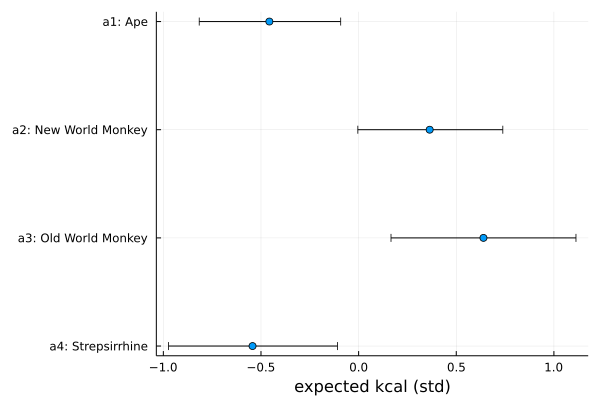

In [65]:
d[!,:K] = standardize(ZScoreTransform, d.kcal_per_g);
clade_counts = maximum(levels(d.clade_id))

@model function model_m5_9(clade_id, K)
    clade_μ = zeros(clade_counts)
    a ~ MvNormal(clade_μ, 0.5)
    σ ~ Exponential(1)
    K ~ MvNormal(a[clade_id], σ)
end

m5_9 = sample(model_m5_9(d.clade_id, d.K), NUTS(), 1000)
m5_9_df = DataFrame(m5_9)
# get rid of square brackets in a params
rename!(n -> replace(n, r"\[|\]" => ""), m5_9_df)

pars = [:a1, :a2, :a3, :a4]
p_names = map(v -> "$(v[1]): $(v[2])", zip(pars, levels(d.clade)))

coeftab_plot(m5_9_df; pars=pars, pars_names=p_names, xlab="expected kcal (std)")

## Code 5.53

In [66]:
# it took me a while to find a seed which make Slytherin to stand out. 
# So it is just a seed, not the model property
Random.seed!(31)
d[!,:house] = sample(1:4, nrow(d));

## Code 5.54

In [67]:
house_counts = maximum(levels(d.house))

@model function model_m5_10(clade_id, house, K)
    clade_μ = zeros(clade_counts)
    house_μ = zeros(house_counts)
    a ~ MvNormal(clade_μ, 0.5)
    h ~ MvNormal(house_μ, 0.5)
    σ ~ Exponential(1)
    μ = a[clade_id] .+ h[house]
    K ~ MvNormal(μ, σ)
end

m5_10 = sample(model_m5_10(d.clade_id, d.house, d.K), NUTS(), 1000)
m5_10_df = DataFrame(m5_10)
precis(m5_10_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│  a[1] │ -0.4983  0.2807  -0.9165  -0.5088  -0.0351      ▁▁▃▇█▆▄▁▁ │
│  a[2] │  0.2824  0.2874   -0.203   0.2816   0.7225      ▁▂▄▇█▆▄▁▁ │
│  a[3] │  0.6566  0.3311   0.1175   0.6597   1.1682  ▁▁▁▁▃▅███▄▂▁▁ │
│  a[4] │  -0.518  0.3104  -0.9895  -0.5226  -0.0099     ▁▂▅▇█▆▄▂▁▁ │
│  h[1] │ -0.0292  0.2937  -0.4857  -0.0238   0.4206   ▁▁▁▃▆██▅▂▁▁▁ │
│  h[2] │ -0.1539  0.3263   -0.651  -0.1561   0.3735    ▁▁▂▆▇█▆▃▂▁▁ │
│  h[3] │ -0.1388  0.3063  -0.6165  -0.1344   0.3677     ▁▂▅██▇▄▂▁▁ │
│  h[4] │  0.2955  0.2835  -0.1574    0.298   0.7404    ▁▁▁▁▃▆█▇▃▁▁ │
│     σ │  0.7929    0.12   0.6192   0.7768   0.9898     ▁▅█▆▄▁▁▁▁▁ │
└───────┴───────────────────────────────────────────────────────────┘
